In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
#pd.reset_option('display.float_format')

In [197]:
data = pd.read_csv("./data/kc_house_data.csv")

# Misc Functions

In [198]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

def checkForVIF(df_ColsToCheck):
#     X = df[x_cols]
    vif = [variance_inflation_factor(df_ColsToCheck.values, i) for i in range(df_ColsToCheck.shape[1])]
    vifresults = list(zip(df_ColsToCheck.columns, vif))
    return vifresults

def scaleData_min_max (df_continuous):
    scaler = MinMaxScaler()
    # transform data
    scaled_df = scaler.fit_transform(df_continuous)
    scaled_df = pd.DataFrame(scaled_df, columns=df_continuous.columns)
    scaled_df_no_index = scaled_df.reset_index(drop=True)
    return scaled_df_no_index

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


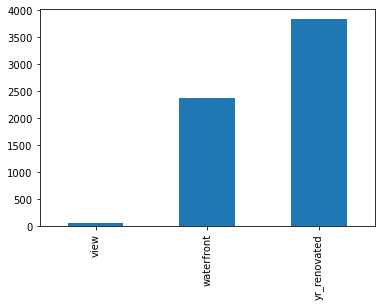

In [199]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

In [200]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)
# data_No_NAs["YearsSinceRenovation"] = data_No_NAs.apply(lambda row : (2020 - row['yr_renovated']) if row["yr_renovated"] != 0 else (2020 - row["yr_built"]), axis=1)
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')

data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

In [201]:
df_check2 = data_No_NAs.loc[data_No_NAs.waterfront ==1]
len(df_check2)

146

In [202]:
data_No_NAs.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,65,981
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,69,981
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,87,980
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,55,981
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,33,980


In [203]:
df_check2 = data_No_NAs.loc[data_No_NAs.id ==8732030490]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3
4252,8732030490,12/22/2014,261500.0,4,2.5,2460,7800,1.0,0.0,0.0,3,8,1500,960.0,1977,1977.0,98023,47.3081,-122.384,2210,7800,43,980


In [204]:
missing = data.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
AgeOfHome        0
zipcode_str      0
ZipFirst3        0
dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    A. "Finding" Target Market

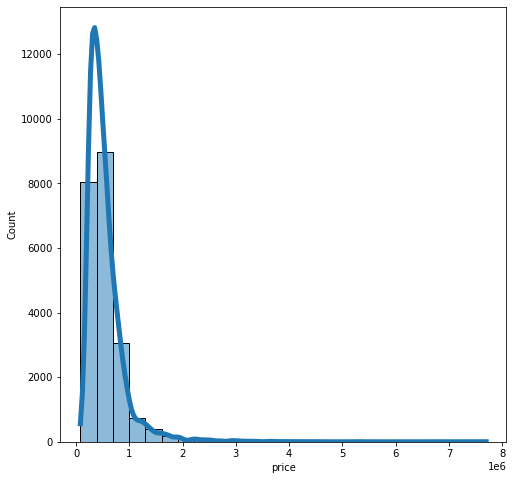

In [205]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

Majority of Homes Priced <$1,000,000

Establish Target Market --> Price Range That Contains Most Data Points 

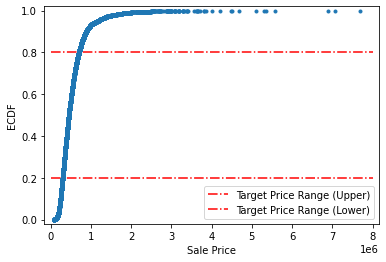

In [206]:
x = np.sort(data_No_NAs['price'])
y = np.arange(1, len(x)+1)/ len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.hlines(.8, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Upper)', data=None)
_ = plt.hlines(.2, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Lower)', data=None)
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Sale Price')
plt.legend(loc="lower right")
plt.margins(.02) # keeps data from running off edge
plt.show()

In [207]:
pd.options.display.float_format = '{:,.0f}'.format
data_No_NAs.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome
count,"21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597"
mean,"4,580,474,288","540,297",3,2,"2,080","15,099",1,0,0,3,8,"1,789",286,"1,971","1,973","98,078",48,-122,"1,987","12,758",49
std,"2,876,735,716","367,368",1,1,918,"41,413",1,0,1,1,1,828,440,29,29,54,0,0,685,"27,274",29
min,"1,000,102","78,000",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5
25%,"2,123,049,175","322,000",3,2,"1,430","5,040",1,0,0,3,7,"1,190",0,"1,951","1,954","98,033",47,-122,"1,490","5,100",23
50%,"3,904,930,410","450,000",3,2,"1,910","7,618",2,0,0,3,7,"1,560",0,"1,975","1,977","98,065",48,-122,"1,840","7,620",45
75%,"7,308,900,490","645,000",4,2,"2,550","10,685",2,0,0,4,8,"2,210",550,"1,997","1,999","98,118",48,-122,"2,360","10,083",69
max,"9,900,000,190","7,700,000",33,8,"13,540","1,651,359",4,1,4,5,13,"9,410","4,820","2,015","2,015","98,199",48,-121,"6,210","871,200",120


50% Data Points Between $800,000 - and $250,000, Remove Outliers on both sides and rerun, currently mean and standard deviation impacted significantly by large home values

In [208]:
lower = 250000
upper = 800000
log_lower = np.log(lower)
log_upper = np.log(upper)

data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

# q_high = data_No_NAs['log_price'].quantile(.85)
# q_low = data_No_NAs['log_price'].quantile(.25)

q_high = log_upper
q_low = log_lower

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170"
mean,"4,647,897,508","467,108",3,2,"1,960","14,321",1,0,0,3,8,"1,688",266,"1,972","1,974","98,079",48,-122,"1,911","12,335",48,13
std,"2,874,291,078","144,243",1,1,680,"38,328",1,0,1,1,1,659,398,29,29,51,0,0,545,"26,144",29,0
min,"1,000,102","250,200",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5,12
25%,"2,206,700,094","345,000",3,2,"1,460","4,895",1,0,0,3,7,"1,200",0,"1,952","1,954","98,034",47,-122,"1,500","5,000",22,13
50%,"3,982,700,188","445,000",3,2,"1,880","7,337",2,0,0,3,7,"1,530",0,"1,977","1,978","98,072",48,-122,"1,820","7,406",43,13
75%,"7,349,615,080","570,000",4,2,"2,390","10,140",2,0,0,4,8,"2,080",520,"1,998","1,999","98,118",48,-122,"2,250","9,736",68,13
max,"9,900,000,190","799,990",33,8,"5,820","1,651,359",4,1,4,5,11,"5,450","2,196","2,015","2,015","98,199",48,-121,"4,670","560,617",120,14


In [209]:
np.exp(q_high)

800000.0000000003

Mean now closer to 50%

Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <12000. > 4000, Homes that have sold more than 1 on target years

In [210]:
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bedrooms'] < (7)] # > 10 Bedrooms
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bathrooms'] < (6)]  # > 6 Bathrooms
data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bathrooms'] >= 1]  # > 6 Bathrooms
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 12000)] #4000, 12000
data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['AgeOfHome'] < 50]
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

In [211]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
len(df_check2)

1

In [212]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3,log_price
16556,2923039243,11/13/2014,"340,000",4,1,1200,11834,1,1,3,3,6,1200,0,1972,"1,972",98070,47,-122,1670,47462,48,980,13


In [213]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410"
mean,"4,928,127,022","457,895",4,2,"2,245","8,055",1,0,0,3,8,"1,522",723,"1,984","1,984","98,063",48,-122,"2,033","8,272",36,13
std,"2,858,022,630","144,636",1,1,632,"1,865",0,0,1,1,1,490,298,11,11,50,0,0,476,"2,489",11,0
min,"11,300,120","250,600",1,1,"1,090","4,000",1,0,0,2,6,590,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,12
25%,"2,473,410,442","330,000",3,2,"1,790","7,034",1,0,0,3,7,"1,210",500,"1,977","1,977","98,030",47,-122,"1,720","7,228",31,13
50%,"4,099,550,150","440,000",4,2,"2,120","7,930",1,0,0,3,8,"1,380",690,"1,979","1,979","98,052",48,-122,"1,960","8,024",41,13
75%,"7,696,115,125","555,000",4,3,"2,530","9,528",1,0,0,4,8,"1,668",900,"1,989","1,989","98,088",48,-122,"2,270","9,551",43,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,14


In [214]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

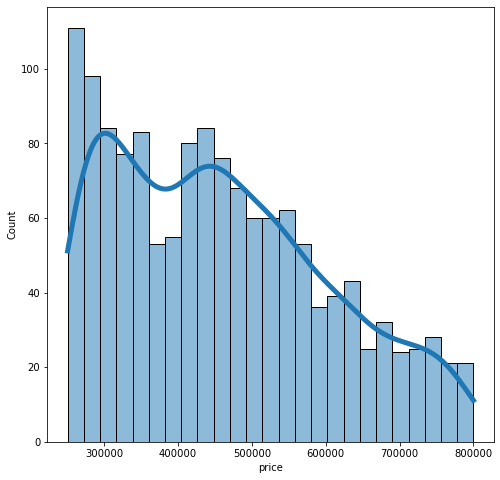

In [215]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

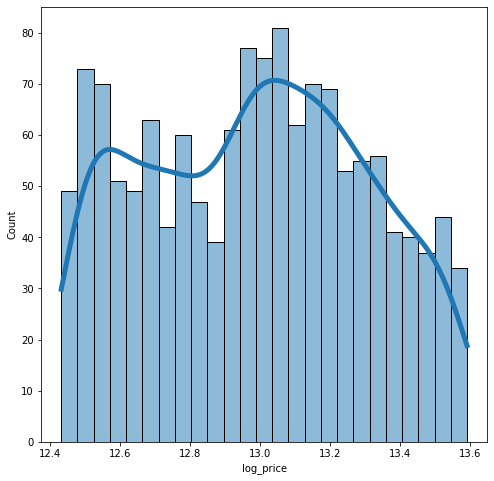

In [216]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

In [217]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398"
mean,"4,928,521,486","458,139",4,2,"2,247","8,046",1,0,0,3,8,"1,524",723,"1,984","1,984","98,063",48,-122,"2,031","8,260",36,13
std,"2,851,332,214","144,653",1,1,632,"1,858",0,0,1,1,1,491,298,11,11,50,0,0,476,"2,493",11,0
min,"11,300,120","250,600",1,1,"1,090","4,000",1,0,0,2,6,590,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,12
25%,"2,473,410,788","330,000",3,2,"1,790","7,030",1,0,0,3,7,"1,217",500,"1,977","1,977","98,030",47,-122,"1,720","7,225",31,13
50%,"4,099,550,150","440,000",4,2,"2,120","7,925",1,0,0,3,8,"1,390",690,"1,979","1,979","98,052",48,-122,"1,960","8,008",41,13
75%,"7,691,900,202","556,875",4,3,"2,530","9,517",1,0,0,4,8,"1,670",900,"1,989","1,989","98,092",48,-122,"2,270","9,534",43,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,14


##    B. Scaling, Converting & Eliminating Multicolinearity

In [218]:
model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_lot', 'floors', 
                                                  'sqft_above', 'sqft_basement', 'sqft_living15', 'AgeOfHome']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]
# model1_Continuous_variables = data_Target_Homes_Continuous.columns

In [219]:
#Scale Continuous initial data
scaled_df_no_index = scaleData_min_max (data_Target_Homes_Continuous)

Convert Categorical To Dummy

In [220]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)



data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome'],
                                                                                     axis = 1)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

In [221]:
data_Target_Homes_Scaled_WithDummies.describe()

,id,price,yr_built,yr_renovated,zipcode,lat,long,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,AgeOfHome
count,"1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398"
mean,"4,928,521,486","458,139","1,984","1,984","98,063",48,-122,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
std,"2,851,332,214","144,653",11,11,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
min,"11,300,120","250,600","1,971","1,971","98,001",47,-122,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,"2,473,410,788","330,000","1,977","1,977","98,030",47,-122,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50%,"4,099,550,150","440,000","1,979","1,979","98,052",48,-122,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75%,"7,691,900,202","556,875","1,989","1,989","98,092",48,-122,13,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1
max,"9,839,300,775","799,950","2,015","2,015","98,199",48,-121,14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [222]:
model1_Constantants = ['id,','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_2', 'condition_3','condition_4', 'condition_5', 'grade_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981']

Next Find Correlation and Mulicolinearity

In [223]:
model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

,cc
pairs,
"(grade_7, grade_8)",1
"(sqft_above, floors)",1


In [224]:
model1_Categorical_variables_to_remove = ['grade_7']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['floors']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

,cc
pairs,


In [225]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.0530396120993109),
 ('view_1', 1.0434016762287188),
 ('view_2', 1.1060144825013791),
 ('view_3', 1.1251273102667303),
 ('view_4', 1.0176444709474008),
 ('condition_4', 1.6433593188521987),
 ('condition_5', 1.1492311692069066),
 ('grade_8', 2.5417289297787162),
 ('grade_9', 2.0949768286835626),
 ('grade_10', 1.4263095789927558),
 ('ZipFirst3_981', 1.6303978597567368),
 ('bedrooms', 19.023815370209576),
 ('bathrooms', 13.952580082263925),
 ('sqft_lot', 7.317364085951968),
 ('sqft_above', 13.585708636875983),
 ('sqft_basement', 10.121485185172391),
 ('sqft_living15', 13.724680291459496),
 ('AgeOfHome', 10.147565355521953)]

In [226]:
# Create new variables Rooms and SquartFt given high vifs
data_Review_Colinearity_Model1["Rooms"] = data_Review_Colinearity_Model1['bedrooms']*data_Review_Colinearity_Model1['bathrooms']
data_Review_Colinearity_Model1["squareFt"] = data_Review_Colinearity_Model1['sqft_above']*data_Review_Colinearity_Model1['sqft_living15']
data_Review_Colinearity_Model1 = data_Review_Colinearity_Model1.drop(['bedrooms','bathrooms', 'sqft_living15', 'sqft_above'], axis=1)
checkForVIF(data_Review_Colinearity_Model1)

<ipython-input-226-2ceac4c2f0a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Review_Colinearity_Model1["Rooms"] = data_Review_Colinearity_Model1['bedrooms']*data_Review_Colinearity_Model1['bathrooms']
<ipython-input-226-2ceac4c2f0a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Review_Colinearity_Model1["squareFt"] = data_Review_Colinearity_Model1['sqft_above']*data_Review_Colinearity_Model1['sqft_living15']


[('waterfront_1', 1.0427033754183272),
 ('view_1', 1.035693858915461),
 ('view_2', 1.0976835044772075),
 ('view_3', 1.1180318142861074),
 ('view_4', 1.010019993995822),
 ('condition_4', 1.639202310539509),
 ('condition_5', 1.1407656734147844),
 ('grade_8', 2.2271871167386244),
 ('grade_9', 1.9294146340782101),
 ('grade_10', 1.4310971092575098),
 ('ZipFirst3_981', 1.5843168896933546),
 ('sqft_lot', 7.148697299521004),
 ('sqft_basement', 9.173327647353837),
 ('AgeOfHome', 8.654812316188544),
 ('Rooms', 5.4527499309349485),
 ('squareFt', 4.254029087579483)]

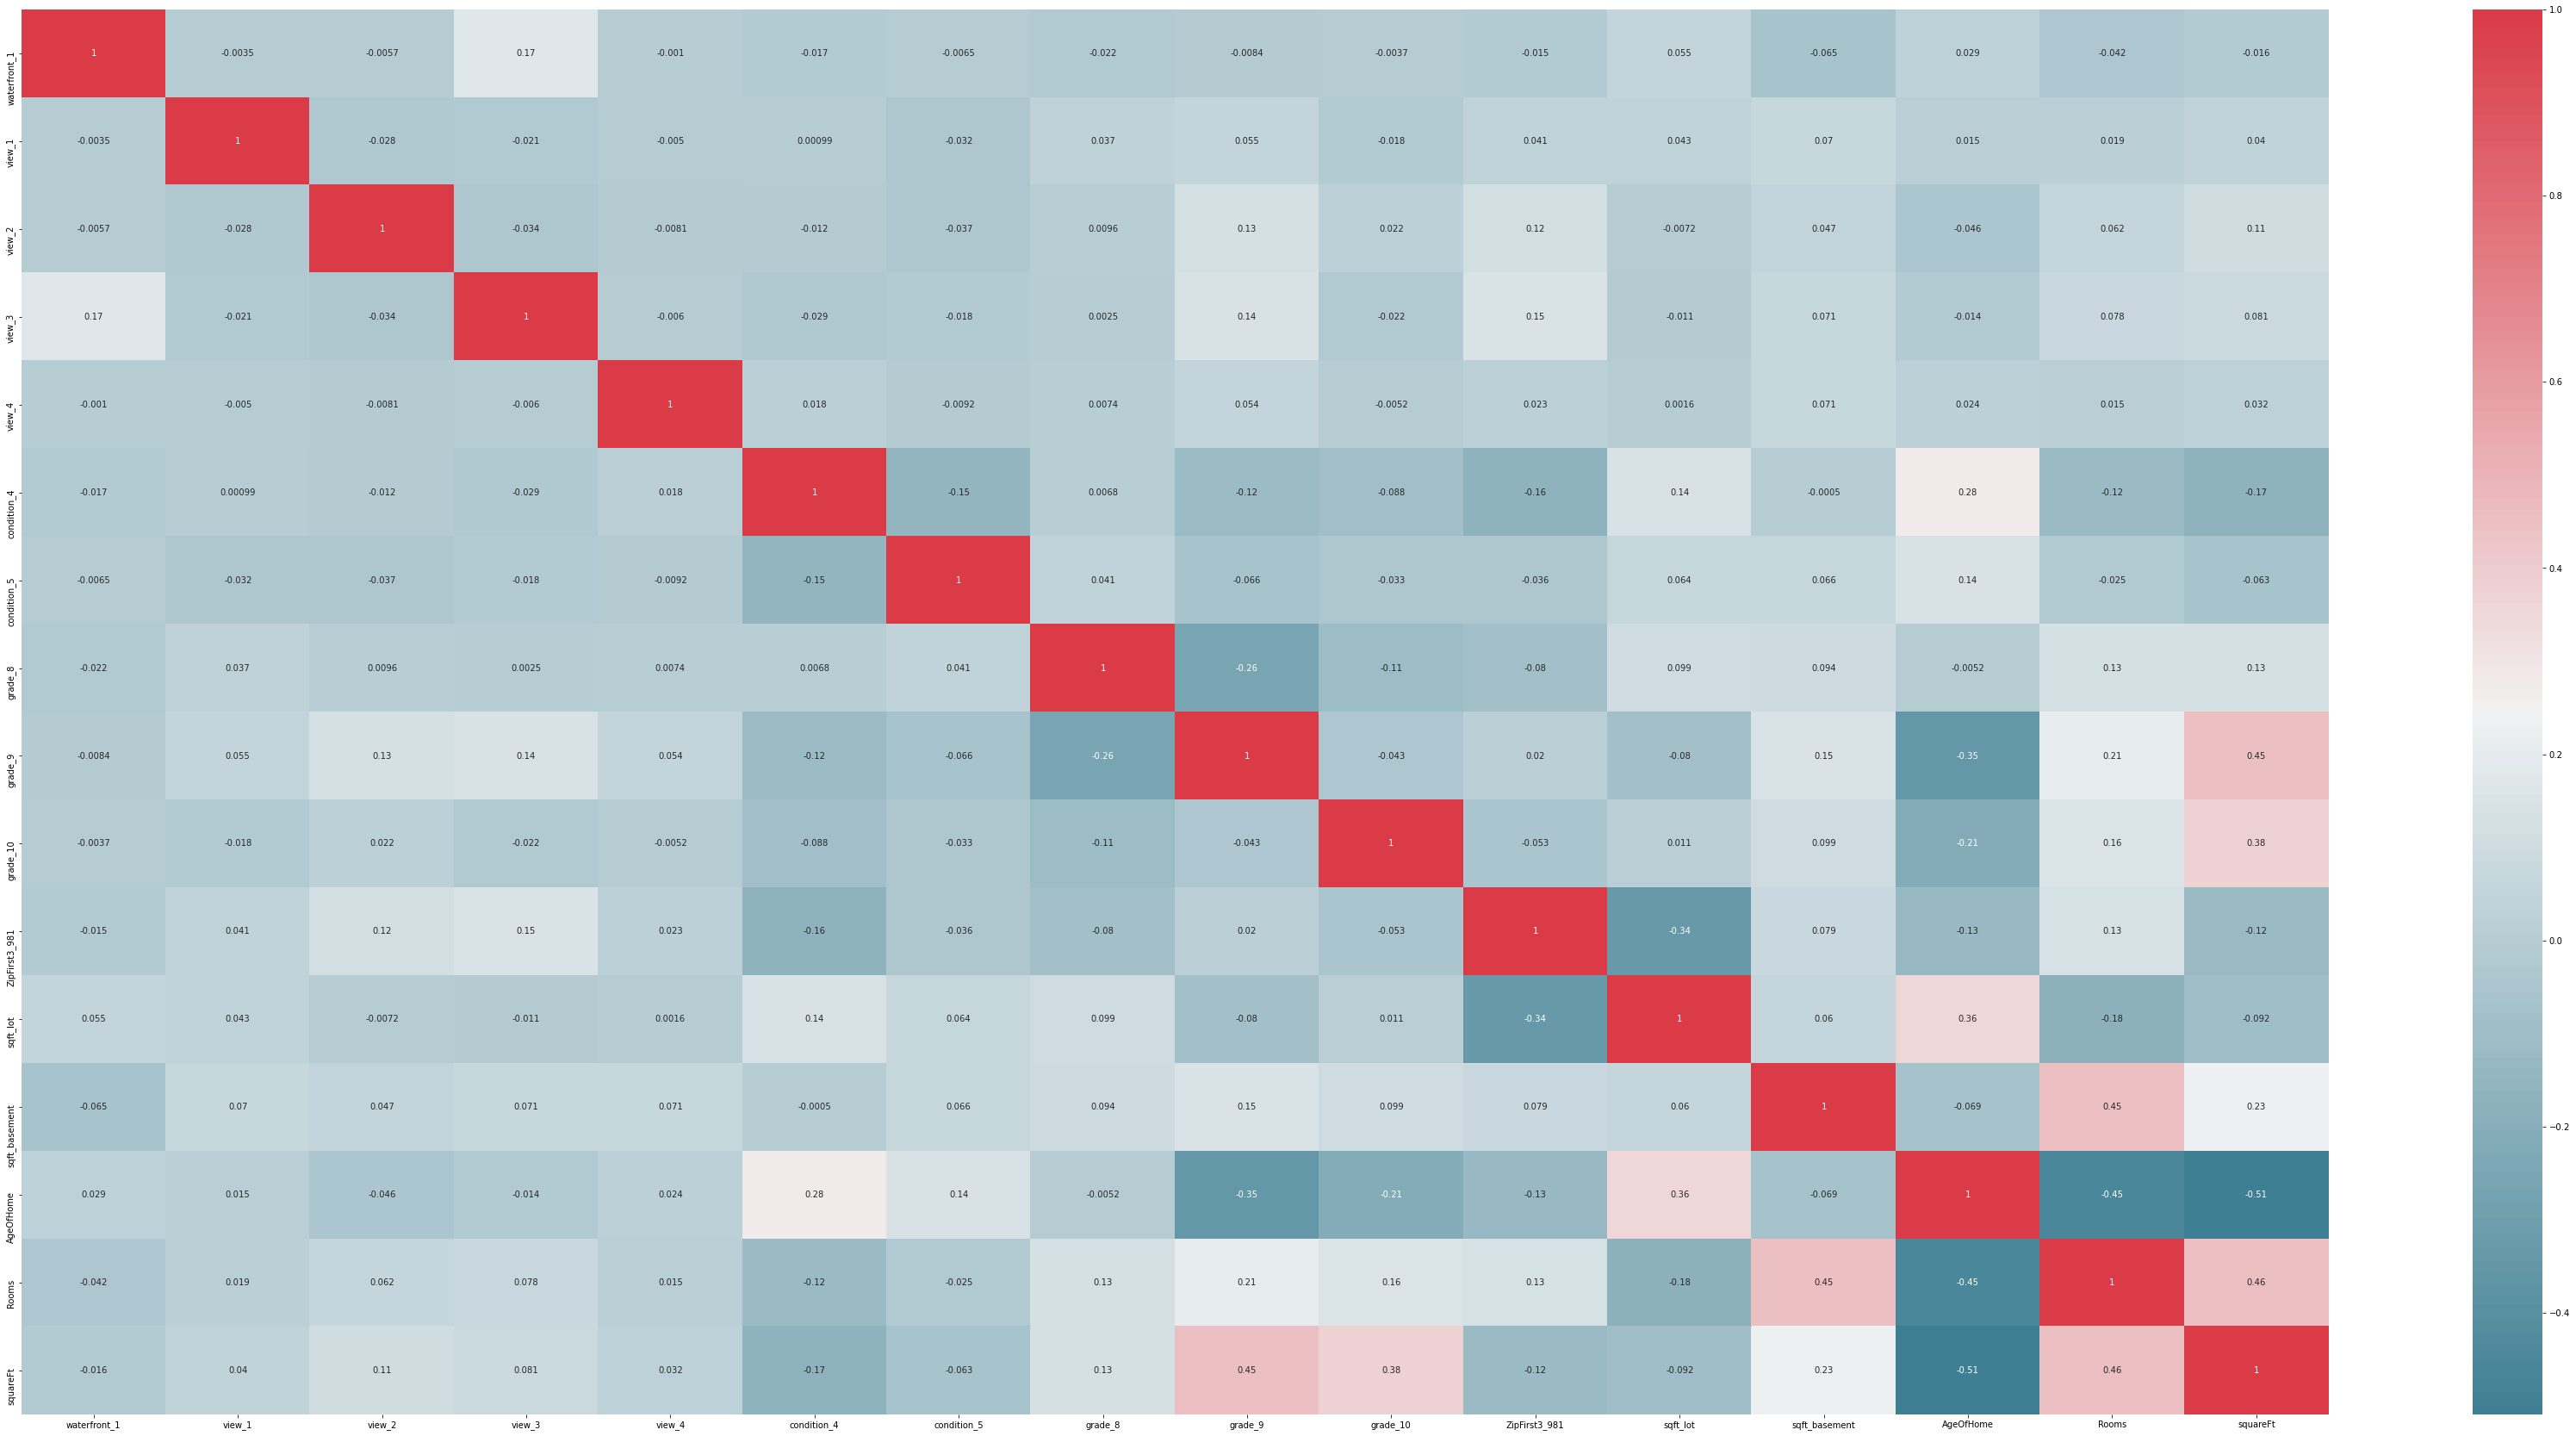

In [227]:
correlation_heatmap(data_Review_Colinearity_Model1)

In [228]:
#Remove Columns from our list of continuous and Categorical values indentified in VIF and Colinear testing

model1_Categorical_variables_to_remove = ['NA']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['sqft_above','sqft_living15','bathrooms','bedrooms']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


data_Target_Homes_Scaled_WithDummies["Rooms"] = data_Review_Colinearity_Model1["Rooms"]
model1_Continuous_variables.append("Rooms")
data_Target_Homes_Scaled_WithDummies["squareFt"] = data_Review_Colinearity_Model1["squareFt"]
model1_Continuous_variables.append("squareFt")

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [229]:
FieldsMovingForward = ['id', 'price','log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [230]:
with open('regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)

with open('regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [231]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()

,id,price,log_price,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,ZipFirst3_981,sqft_lot,sqft_basement,AgeOfHome,Rooms,squareFt
count,1.398000e+03,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000
mean,4.928521e+09,458139.045780,12.985147,98063.205293,47.560182,-122.202755,0.000715,0.017167,0.043634,0.024320,0.001431,0.288269,0.055794,0.404149,0.090129,0.018598,0.243205,0.505796,0.333091,0.701782,0.141816,0.104209
std,2.851332e+09,144653.134602,0.316822,49.587201,0.149958,0.121169,0.026745,0.129941,0.204352,0.154097,0.037810,0.453119,0.229606,0.490902,0.286469,0.135149,0.429171,0.232289,0.137330,0.250632,0.090540,0.105204
min,1.130012e+07,250600.000000,12.431613,98001.000000,47.193700,-122.456000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473411e+09,330000.000000,12.706848,98030.000000,47.443475,-122.298000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.378781,0.230415,0.590909,0.080357,0.043972
50%,4.099550e+09,440000.000000,12.994530,98052.000000,47.555250,-122.194000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.490625,0.317972,0.818182,0.125000,0.072421
75%,7.691900e+09,556875.000000,13.230094,98092.000000,47.706025,-122.139000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.689594,0.414747,0.863636,0.187500,0.122574
max,9.839301e+09,799950.000000,13.592305,98199.000000,47.777200,-121.417000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.858896


# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions with 7 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [232]:
# Get Data From Above - Build Upon Model 1
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [233]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","SchoolDistRankBin"]], on="id")
# data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./data/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)

#get points of interest within 7 miles
df_Proximity_To_FortuneFives = pd.read_excel('./data/df_Counts_of_Fortune500_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.merge(df_Proximity_To_FortuneFives, on="id")


# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                                          'HotnessScore':'ZipHotnessScore'}, inplace=True)

data_with_Hot_Dist_POints.fillna(0, inplace=True)

In [234]:
data_with_Hot_Dist_POints.head()

,id,price,log_price,date,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,ZipFirst3_981,sqft_lot,sqft_basement,AgeOfHome,Rooms,squareFt,ZipHotnessScore,SchoolDistRankBin,Attractions1,Attractions2,Attractions3,Over10,Over20,Under10
0,9297300055,650000.0,13.384728,1/24/2015,98126,47.5714,-122.375,0,0,0,1,0,0,0,0,1,0,1,0.125000,0.447005,0.818182,0.214286,0.148253,86.40,Top30,182.0,60.0,1350,4.0,1.0,6.0
1,7955080270,322500.0,12.683858,12/3/2014,98058,47.4276,-122.157,0,0,0,0,0,0,0,0,0,0,0,0.332375,0.359447,0.772727,0.187500,0.066295,75.70,Top60,106.0,32.0,561,7.0,1.0,3.0
2,3626039271,585000.0,13.279367,2/5/2015,98117,47.6989,-122.369,0,0,0,0,0,0,0,0,0,0,1,0.568750,0.456221,0.772727,0.026786,0.019392,89.25,Top30,150.0,48.0,1203,5.0,0.0,6.0
3,1189001180,425000.0,12.959844,6/3/2014,98122,47.6113,-122.297,0,0,0,0,0,0,0,0,0,0,1,0.250000,0.253456,0.818182,0.089286,0.023376,90.85,Top30,247.0,84.0,1756,3.0,1.0,7.0
4,3342103156,461000.0,13.041153,6/18/2014,98056,47.5228,-122.199,0,0,0,0,0,0,0,0,1,0,0,0.284750,0.364055,0.204545,0.160714,0.118847,74.34,Top100,160.0,46.0,832,0.0,1.0,10.0


##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [235]:
model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
                               'Under10', 'Over10', 'Over20']

model2_Categorical_variables  = ['Sch_d_Top15','Sch_d_Top30', 'Sch_d_Top60']


data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [236]:
#Scale Continuous initial data
scaled_df_no_index2 = scaleData_min_max (data_with_Hot_Dist_POints_Continuous)

In [237]:
#create dummies for new categorical
dummies_SchoolRankBins = pd.get_dummies(data_with_Hot_Dist_POints['SchoolDistRankBin'], prefix='Sch_d', drop_first=True)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop('SchoolDistRankBin', axis=1)

#Add dummies back to main DF
data_with_Hot_Dist_POints_WithDummies = pd.concat([data_with_Hot_Dist_POints, dummies_SchoolRankBins], axis=1)

#drop original features that got scaled above
data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.drop(model2_Continuous_variables, axis=1)

data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.reset_index(drop=True)

#bring newly scaled and dummies together
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints_WithDummies, scaled_df_no_index2], axis=1)

In [238]:
data_with_Hot_Dist_POints.head()

,id,price,log_price,date,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,ZipFirst3_981,sqft_lot,sqft_basement,AgeOfHome,Rooms,squareFt,Sch_d_Top15,Sch_d_Top30,Sch_d_Top60,ZipHotnessScore,Attractions1,Attractions2,Attractions3,Under10,Over10,Over20
0,9297300055,650000.0,13.384728,1/24/2015,98126,47.5714,-122.375,0,0,0,1,0,0,0,0,1,0,1,0.125000,0.447005,0.818182,0.214286,0.148253,0,1,0,0.763508,0.612457,0.634409,0.754783,0.500000,0.2500,0.05
1,7955080270,322500.0,12.683858,12/3/2014,98058,47.4276,-122.157,0,0,0,0,0,0,0,0,0,0,0,0.332375,0.359447,0.772727,0.187500,0.066295,0,0,1,0.526572,0.349481,0.333333,0.297391,0.250000,0.4375,0.05
2,3626039271,585000.0,13.279367,2/5/2015,98117,47.6989,-122.369,0,0,0,0,0,0,0,0,0,0,1,0.568750,0.456221,0.772727,0.026786,0.019392,0,1,0,0.826616,0.501730,0.505376,0.669565,0.500000,0.3125,0.00
3,1189001180,425000.0,12.959844,6/3/2014,98122,47.6113,-122.297,0,0,0,0,0,0,0,0,0,0,1,0.250000,0.253456,0.818182,0.089286,0.023376,0,1,0,0.862046,0.837370,0.892473,0.990145,0.583333,0.1875,0.05
4,3342103156,461000.0,13.041153,6/18/2014,98056,47.5228,-122.199,0,0,0,0,0,0,0,0,1,0,0,0.284750,0.364055,0.204545,0.160714,0.118847,0,0,0,0.496457,0.536332,0.483871,0.454493,0.833333,0.0000,0.05


Check For Colinearity - feed all relevant categorical and dummy variables into colinearity review

In [239]:
model2_Categorical_variables_to_remove = ['NA']
# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

,cc
pairs,
"(Attractions3, Attractions1)",0.956391
"(Attractions2, Attractions3)",0.945648
"(Attractions1, Attractions2)",0.916106
"(Under10, Attractions1)",0.834971
"(Under10, Attractions3)",0.799067
"(Attractions2, Under10)",0.774881
"(ZipHotnessScore, ZipFirst3_981)",0.719242
"(ZipFirst3_981, Sch_d_Top30)",0.704478


In [240]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 4.04810451284485),
 ('Sch_d_Top30', 4.480076099513771),
 ('Sch_d_Top60', 1.9628928465960056),
 ('ZipHotnessScore', 26.847577298219193),
 ('Attractions1', 163.21475311760912),
 ('Attractions2', 59.248980484816876),
 ('Attractions3', 122.8636644431801),
 ('Under10', 29.921225654702702),
 ('Over10', 17.182778395916124),
 ('Over20', 4.346550139537064),
 ('sqft_lot', 8.384880103632696),
 ('sqft_basement', 9.489196613530583),
 ('AgeOfHome', 18.235730844530355),
 ('Rooms', 6.149080127626951),
 ('squareFt', 5.049357825622873),
 ('waterfront_1', 1.0580071367367112),
 ('view_1', 1.0543523379576247),
 ('view_2', 1.1118001503329418),
 ('view_3', 1.1500861708537193),
 ('view_4', 1.0221270384689103),
 ('condition_4', 1.666919758470329),
 ('condition_5', 1.1635072840079717),
 ('grade_8', 2.3752096967225445),
 ('grade_9', 2.00580950630679),
 ('grade_10', 1.4569461468367213),
 ('ZipFirst3_981', 5.586586195670434)]

Drop 

In [241]:
model1_Categorical_variables_to_remove = ['ZipFirst3_981']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['AgeOfHome']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3', 'Under10','ZipHotnessScore']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

,cc
pairs,


In [242]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 3.4120871032267837),
 ('Sch_d_Top30', 2.336438053822637),
 ('Sch_d_Top60', 1.8377601930699483),
 ('Attractions1', 7.542753466445857),
 ('Over10', 6.501587455804783),
 ('Over20', 2.091277112668546),
 ('sqft_lot', 6.7942942308334455),
 ('sqft_basement', 9.049311103737072),
 ('Rooms', 5.657362900645388),
 ('squareFt', 4.638939131783594),
 ('waterfront_1', 1.0500647934035567),
 ('view_1', 1.0435746458087523),
 ('view_2', 1.0888535436920175),
 ('view_3', 1.1129360491134723),
 ('view_4', 1.012006983182217),
 ('condition_4', 1.5696581571430153),
 ('condition_5', 1.1289701118039788),
 ('grade_8', 2.2742491011598536),
 ('grade_9', 1.9195389491404755),
 ('grade_10', 1.4406037813752837)]

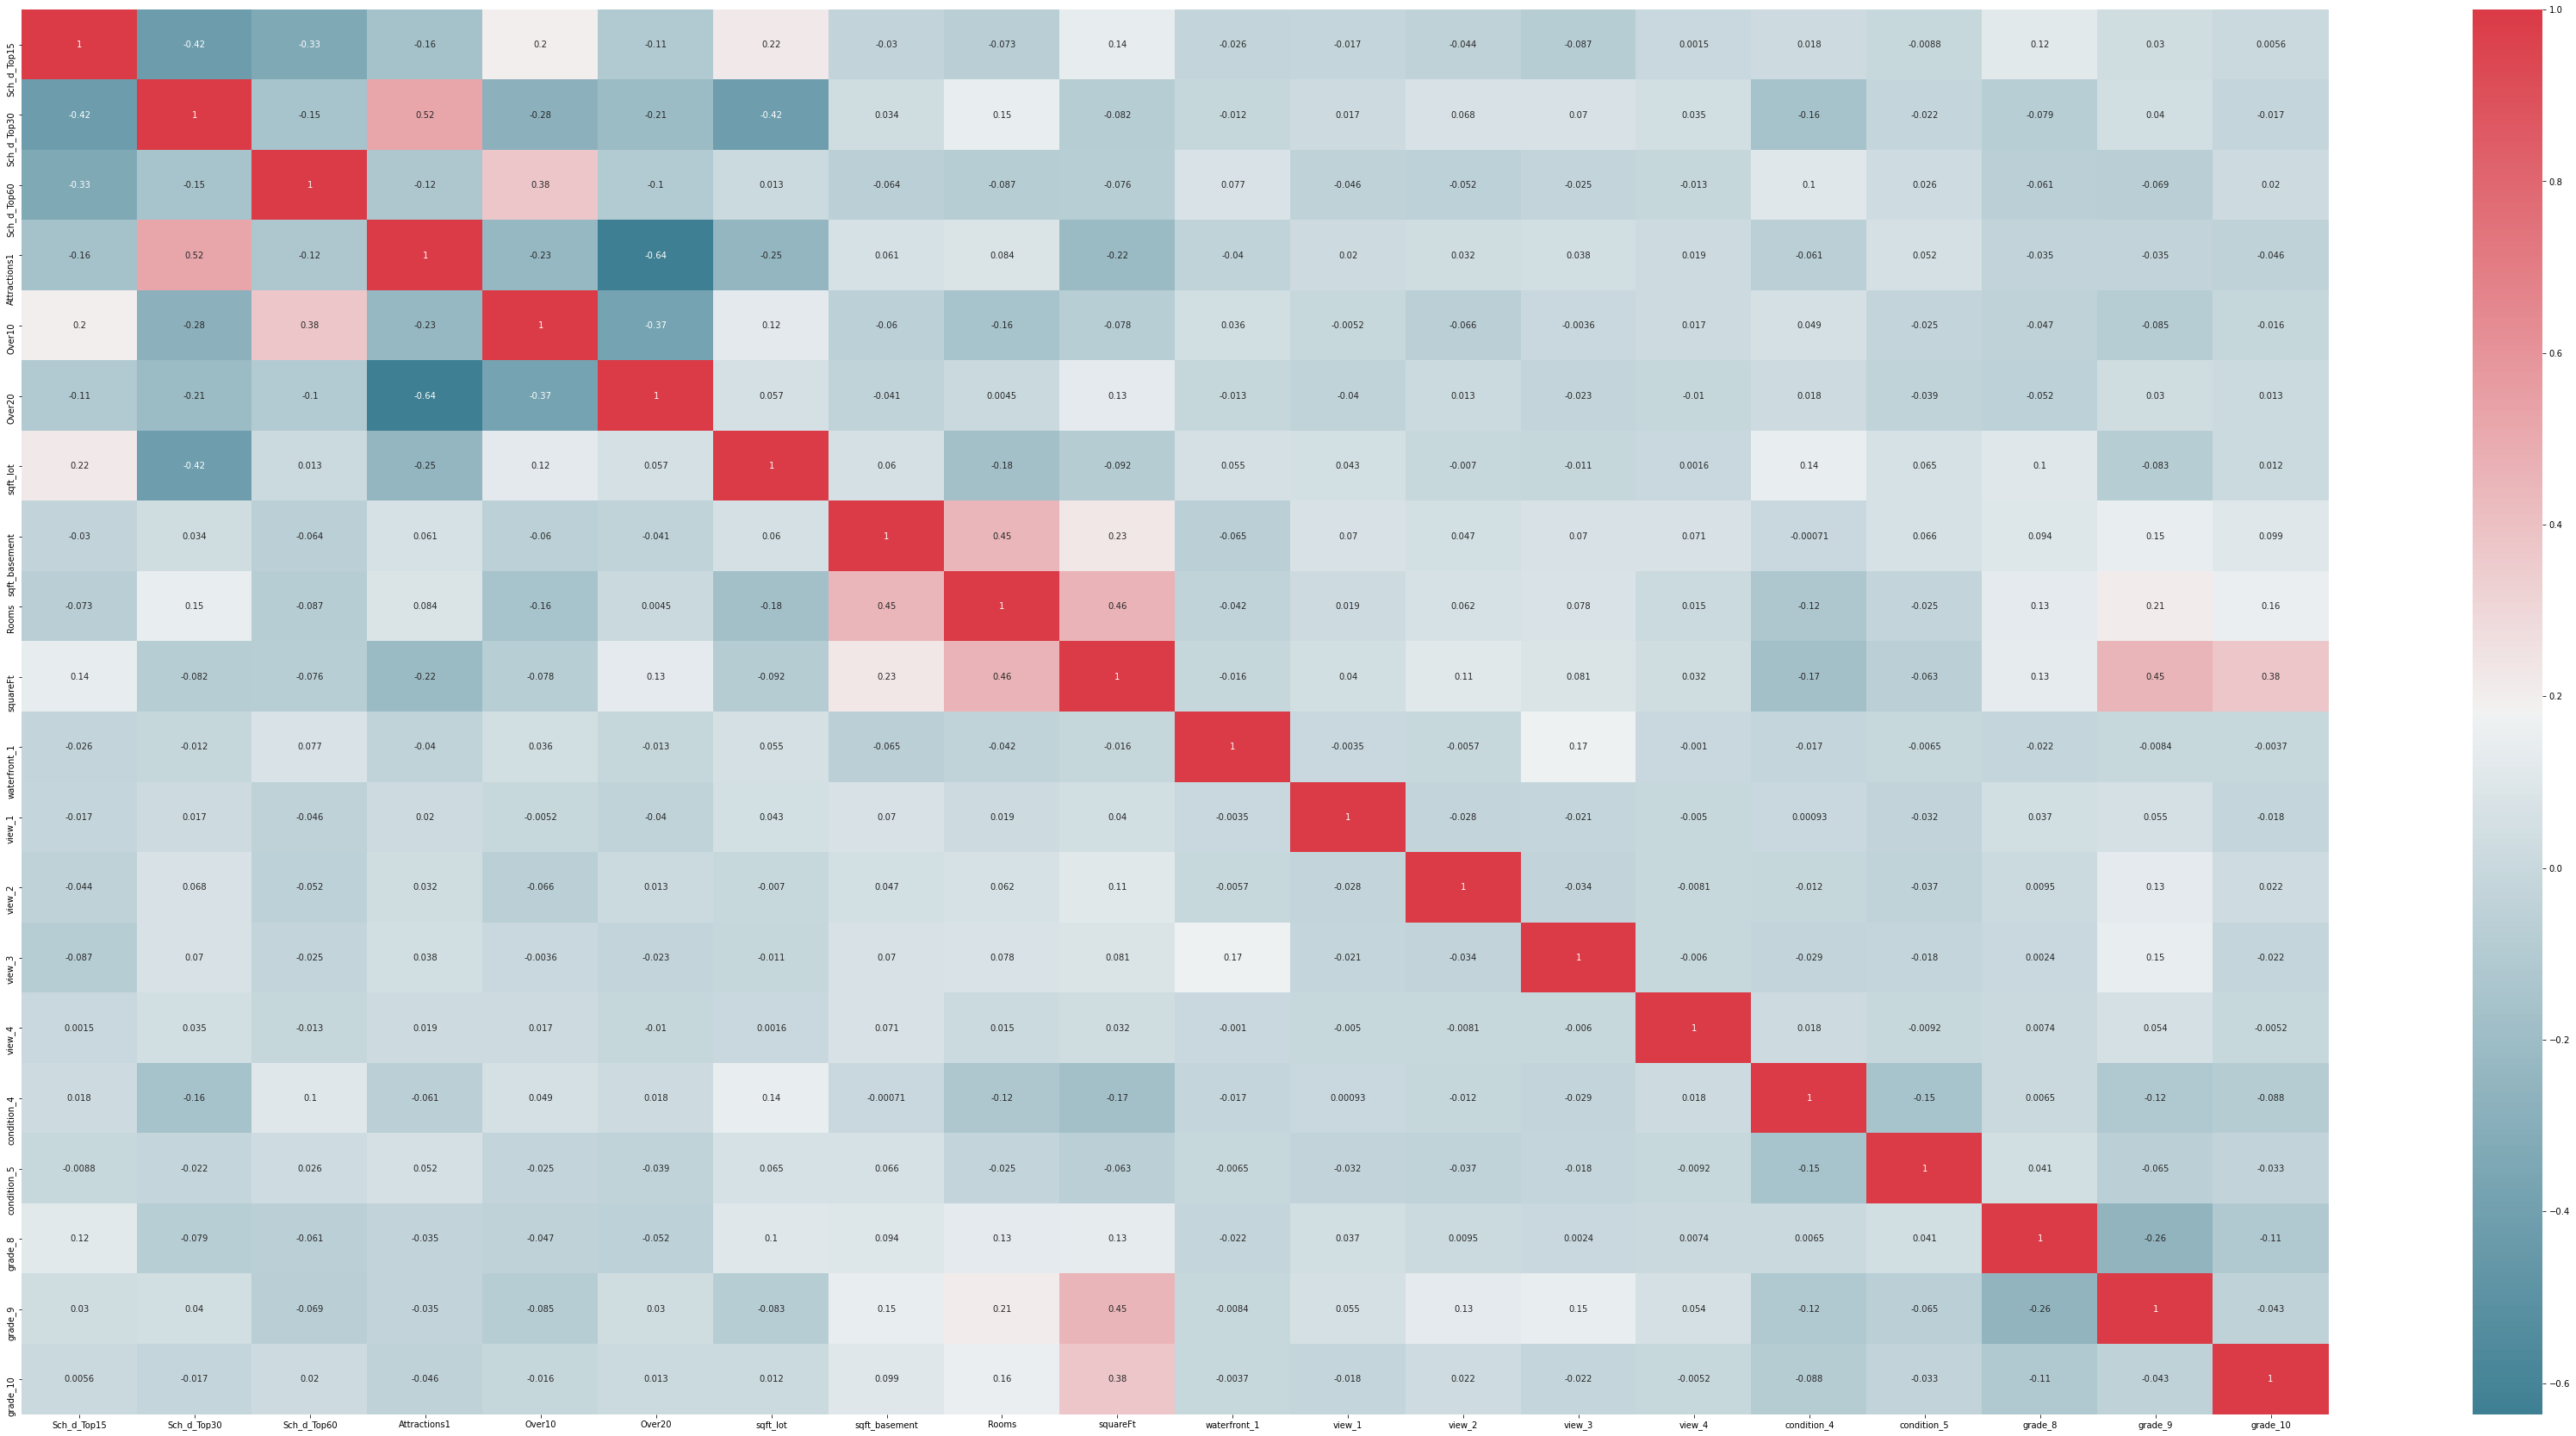

In [243]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [244]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [245]:
import pickle
# Save
with open('regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [246]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [247]:
from dateutil.relativedelta import relativedelta

data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1

data_Model3["yearpriortosale_str"] = data_Model3["yearpriortosale"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['yearpriortosale_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')
df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'yearpriortosale_str', 'yearpriortosale'], axis=1, inplace=True)

In [248]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .6]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .15]

In [249]:
df_data_with_Appraisals.describe()

,id,log_price,zipcode,lat,long,Sch_d_Top15,Sch_d_Top30,Sch_d_Top60,Attractions1,Over10,Over20,sqft_lot,sqft_basement,Rooms,squareFt,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,YrRollingAppraisal,AppraisedLandValue,AppraisedImpsValue,LandToHouseCheck,InflationSinceLastAppraisal,InflationSinceLastAppraisal_abs
count,1.034000e+03,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.0,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.00000,1034.00000,1034.000000,1034.000000,1034.000000
mean,5.194170e+09,12.940729,98065.185687,47.539836,-122.206911,0.415861,0.175048,0.113153,0.381255,0.307785,0.121325,0.492022,0.333910,0.144610,0.103610,0.0,0.014507,0.035783,0.026112,0.001934,0.295938,0.047389,0.382012,0.086074,0.014507,309911.998066,137812.37911,200187.62089,0.404427,0.063729,0.078339
std,2.764297e+09,0.311582,50.113543,0.152626,0.125235,0.493108,0.380192,0.316933,0.176944,0.144819,0.130963,0.229119,0.133446,0.090466,0.107423,0.0,0.119625,0.185839,0.159546,0.043959,0.456684,0.212572,0.486114,0.280608,0.119625,106587.418843,62977.19744,78133.26418,0.091422,0.062178,0.042291
min,1.015500e+09,12.431613,98001.000000,47.193700,-122.456000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059908,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15333.000000,45000.00000,81000.00000,0.111776,-0.142373,0.000000
25%,2.598141e+09,12.669019,98030.000000,47.409950,-122.308000,0.000000,0.000000,0.000000,0.280277,0.187500,0.050000,0.375000,0.230415,0.080357,0.043110,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,223750.250000,88000.00000,143000.00000,0.344871,0.029768,0.047465
50%,4.404600e+09,12.951870,98052.000000,47.536000,-122.202000,0.000000,0.000000,0.000000,0.373702,0.312500,0.050000,0.463563,0.322581,0.125000,0.071394,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,293500.000000,120000.00000,183000.00000,0.393730,0.075606,0.077834
75%,7.853281e+09,13.171154,98106.000000,47.705525,-122.134000,1.000000,0.000000,0.000000,0.480104,0.437500,0.100000,0.653969,0.414747,0.187500,0.122007,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,366667.000000,173000.00000,236000.00000,0.467269,0.102864,0.113874
max,9.839301e+09,13.591116,98199.000000,47.777200,-121.742000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880184,0.714286,0.858896,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,736333.000000,374000.00000,561000.00000,0.599010,0.148077,0.148077


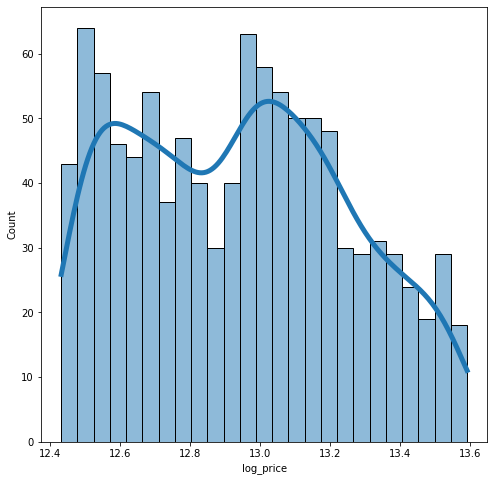

In [250]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [251]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [252]:
# Scale new continuous variables
scaled_df_no_index3 = scaleData_min_max (data_with_Appraisals_Continuous)

In [253]:
df_data_with_Appraisals = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals = df_data_with_Appraisals.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals, scaled_df_no_index3], axis=1)

In [254]:
df_data_with_Appraisals.head()

,id,log_price,date,zipcode,lat,long,Sch_d_Top15,Sch_d_Top30,Sch_d_Top60,Attractions1,Over10,Over20,sqft_lot,sqft_basement,Rooms,squareFt,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,YrRollingAppraisal,AppraisedLandValue,AppraisedImpsValue,LandToHouseCheck,InflationSinceLastAppraisal,InflationSinceLastAppraisal_abs
0,9297300055,13.384728,1/24/2015,98126,47.5714,-122.375,0,1,0,0.612457,0.2500,0.05,0.125000,0.447005,0.214286,0.148253,0,0,0,1,0,0,0,0,1,0,0.877485,0.829787,0.750000,0.630490,0.828173,0.662964
1,1189001180,12.959844,6/3/2014,98122,47.6113,-122.297,0,1,0,0.837370,0.1875,0.05,0.250000,0.253456,0.089286,0.023376,0,0,0,0,0,0,0,0,0,0,0.461397,0.434650,0.227083,0.791362,0.955442,0.912601
2,3342103156,13.041153,6/18/2014,98056,47.5228,-122.199,0,0,0,0.536332,0.0000,0.05,0.284750,0.364055,0.160714,0.118847,0,0,0,0,0,0,0,0,1,0,0.491910,0.273556,0.379167,0.466757,0.832572,0.671594
3,1328310370,12.834681,4/2/2015,98058,47.4431,-122.133,0,0,1,0.301038,0.4375,0.05,0.750625,0.405530,0.107143,0.101227,0,0,0,0,0,1,0,1,0,0,0.356913,0.212766,0.275000,0.490182,0.829052,0.664690
4,6126500060,12.706696,11/24/2014,98108,47.5474,-122.295,0,1,0,0.768166,0.1250,0.05,0.246125,0.460829,0.053571,0.050102,0,0,1,0,0,0,0,0,0,0,0.343043,0.227964,0.106250,0.747925,0.490181,0.000000


Check For Colinearity

In [255]:
model1_Categorical_variables

['waterfront_1',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_8',
 'grade_9',
 'grade_10']

In [256]:
# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

,cc
pairs,
"(YrRollingAppraisal, AppraisedImpsValue)",0.822624
"(AppraisedLandValue, YrRollingAppraisal)",0.798049


In [257]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

C:\Users\rgpih\anaconda3a\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


[('YrRollingAppraisal', 100.84339543616557),
 ('AppraisedLandValue', 29.452618952930667),
 ('AppraisedImpsValue', 36.99116421433375),
 ('LandToHouseCheck', 68.28185069457056),
 ('InflationSinceLastAppraisal', 23.793594832311346),
 ('InflationSinceLastAppraisal_abs', 8.927299127373379),
 ('Sch_d_Top15', 4.54626711607057),
 ('Sch_d_Top30', 3.170505649059671),
 ('Sch_d_Top60', 1.851672482439746),
 ('Attractions1', 17.221529349674455),
 ('Over10', 12.332740810930666),
 ('Over20', 5.385757439334028),
 ('sqft_lot', 7.725816878690854),
 ('sqft_basement', 9.639199917655848),
 ('Rooms', 5.9818324532823),
 ('squareFt', 6.0584586519047),
 ('waterfront_1', nan),
 ('view_1', 1.0554380667102732),
 ('view_2', 1.1297022872352591),
 ('view_3', 1.156176992793296),
 ('view_4', 1.0248211651054628),
 ('condition_4', 1.6732725450331165),
 ('condition_5', 1.1138646509241623),
 ('grade_8', 2.787146192724956),
 ('grade_9', 2.402124357126296),
 ('grade_10', 1.544767071713141)]

In [258]:
model1_Categorical_variables_to_remove = ['waterfront_1']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','LandToHouseCheck',
                                         'InflationSinceLastAppraisal']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Categorical_variables + model1_Continuous_variables 

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

,cc
pairs,


In [259]:
data_Review_Colinearity_Model3["AppraisedValue"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']
data_Review_Colinearity_Model3 = data_Review_Colinearity_Model3.drop(['AppraisedLandValue','AppraisedImpsValue'], axis=1)
df_data_with_Appraisals["AppraisedValue"] = data_Review_Colinearity_Model3["AppraisedValue"]

<ipython-input-259-2e553c05c400>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Review_Colinearity_Model3["AppraisedValue"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']


In [260]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('Sch_d_Top15', 3.298656246885289),
 ('Sch_d_Top30', 2.6677349427292536),
 ('Sch_d_Top60', 1.7732814209185241),
 ('Attractions1', 7.804872829167101),
 ('Over10', 7.026102721061833),
 ('Over20', 2.439544280916362),
 ('view_1', 1.043373482386052),
 ('view_2', 1.0755800858378546),
 ('view_3', 1.108619471064839),
 ('view_4', 1.0187842812960408),
 ('condition_4', 1.6340161395441315),
 ('condition_5', 1.110749829738804),
 ('grade_8', 2.3844128889596665),
 ('grade_9', 2.170624053012173),
 ('grade_10', 1.4484331641251003),
 ('sqft_lot', 6.944490878277804),
 ('sqft_basement', 9.390223299524878),
 ('Rooms', 5.765965171812241),
 ('squareFt', 5.104353902444035),
 ('AppraisedValue', 4.3185234229625635)]

In [261]:
data_Review_Colinearity_Model3.describe()

,Sch_d_Top15,Sch_d_Top30,Sch_d_Top60,Attractions1,Over10,Over20,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,sqft_lot,sqft_basement,Rooms,squareFt,AppraisedValue
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,0.415861,0.175048,0.113153,0.381255,0.307785,0.121325,0.014507,0.035783,0.026112,0.001934,0.295938,0.047389,0.382012,0.086074,0.014507,0.492022,0.333910,0.144610,0.103610,0.084850
std,0.493108,0.380192,0.316933,0.176944,0.144819,0.130963,0.119625,0.185839,0.159546,0.043959,0.456684,0.212572,0.486114,0.280608,0.119625,0.229119,0.133446,0.090466,0.107423,0.097161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059908,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.280277,0.187500,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.230415,0.080357,0.043110,0.017670
50%,0.000000,0.000000,0.000000,0.373702,0.312500,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.463563,0.322581,0.125000,0.071394,0.048591
75%,1.000000,0.000000,0.000000,0.480104,0.437500,0.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.653969,0.414747,0.187500,0.122007,0.112622
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880184,0.714286,0.858896,0.622340


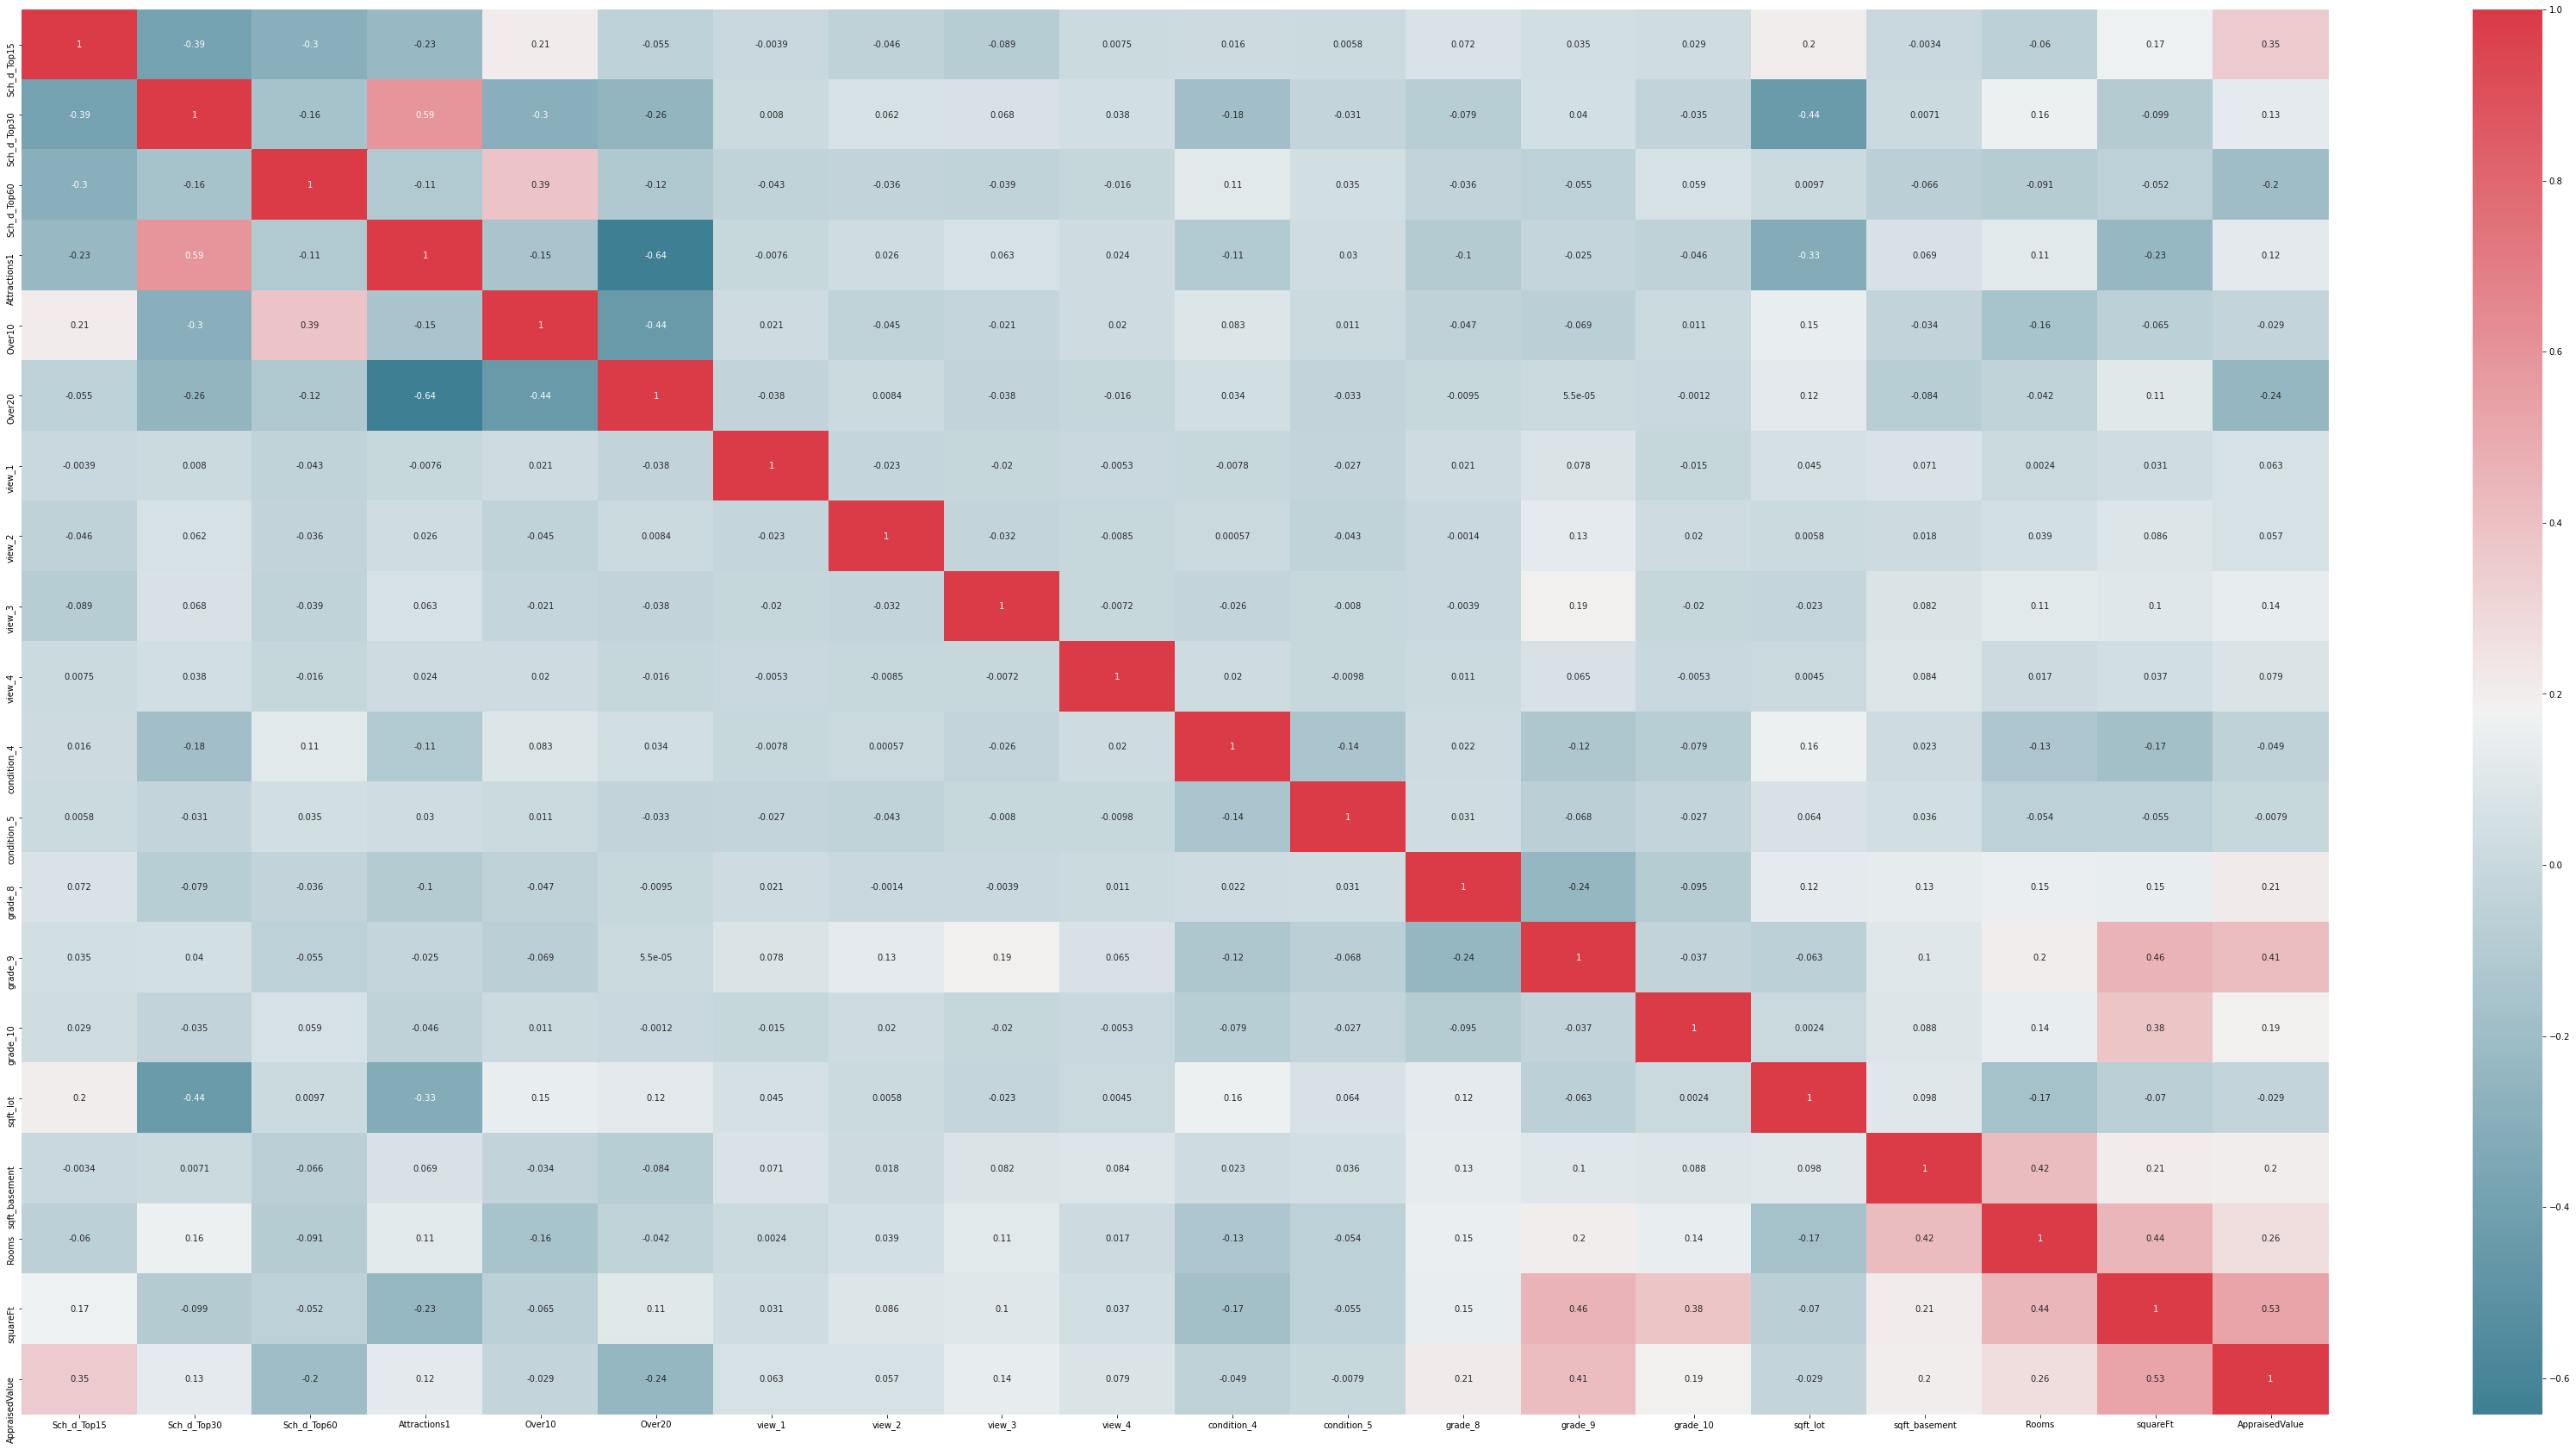

In [262]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [263]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [264]:
import pickle
# Save
with open('regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

# Ensure linearity of features(independent) to target(dependent)

In [ ]:
data_No_Outliers["price"].describe().apply("${0:,.0f}".format)
#"Average" - middle class houses between 367k& 638$k

In [ ]:
data_pred = data_No_Outliers[['YrRollingAppraisal','AppraisedLandValue', 'AppraisedImpsValue', 'LandToHouseCheck',
       'InflationSinceLastAppraisal','bedrooms', 'bathrooms', 'sqft_living',
                                          'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                          'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15','YearsSinceRenovation', 'AgeOfHome', 
                                          'price', 'HotnessScore', 'State Rank','#1Attractions', 
                                          '#2Attractions', '#3Attractions']]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(data_pred):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=data_No_Outliers, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();
